In [1]:
import json
import pandas
import numpy as np
import scipy
import os, sys
from matplotlib import pyplot as plt
from utils import *
import datetime, time
import glob
# from bioinfokit.analys import stat
import textstat
from scipy.stats import kruskal, mannwhitneyu
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from bioinfokit.analys import stat
import seaborn as sns
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

plt.rcParams['text.usetex'] = True  #False #
plt.style.use('ggplot')

rotation = 0
xtick_size=18
xlabel_size=20
ylabel_size=20
legend_size=18

data_root = "./data/"

In [2]:
vocab = json.load(open(f"{data_root}/vocab.json"))
group_names = {-1: r"$\mathbf{Q_{none}}$", 0:r"$\mathbf{Q_{synthesis}}$", 1:r"$\mathbf{Q_{random}}$", 2:r"$\mathbf{Q_{term}}$", 3:r"$\mathbf{Q_{synthesis, random, term}}$"}
colors = sns.color_palette('Spectral', as_cmap=True)

In [3]:
def calc_user_read_to_answer_time(item):
    reading_duration_to_answer = []
    def _to_read(doc):
        start = doc['start']
        end = doc['end']
        for _ in doc['logui_actions']:
            if _['name'] in ['ANSWER_BOX_KEY', 'ANSWER_BOX_FOCUS']:
                end = _['time']
                break
        return (end-start)/1000
    for doc in item.doc_open:
        reading_duration_to_answer.append(_to_read(doc))
    return np.mean(reading_duration_to_answer)


def calc_user_crate_answer_time(item):
    answer_creation_time = []
    def _to_write(doc):
        start = None
        end = None
        answer_creation_time = 0
        for _ in doc['logui_actions']:
            if _['name'] not in ['ANSWER_BOX_KEY', 'ANSWER_BOX_FOCUS']:
                if start is not None:
                    end = _['time']
                    answer_creation_time += (end-start)/1000                    
                    start = None
                    end = None
            else:
                if start is None:
                    start = _['time']
                

        return answer_creation_time
    for doc in item.doc_open:
        answer_creation_time.append(_to_write(doc))
    return np.mean(answer_creation_time)



def calc_user_scrolls(item):
    answer_scroll_num = [np.sum([_['name'] == 'PAGE_SCROLL_START' for _ in doc['logui_actions']]) for doc in item.doc_open]
    
    return np.mean(answer_scroll_num)


def calc_answer_non_stopwords(item):
    user_answers = [doc['user_answer'] for doc in item.doc_open if 'user_answer' in doc]
    
    answer_lengths =[len(set(tokenize.word_tokenize(ans.lower().strip())).intersection(stop_words)) for ans in user_answers]
    return np.mean(answer_lengths) if len(answer_lengths) > 0 else 0


def calc_summary_term_coverage(item):
    topic_terms = set([w for t in vocab[str(item.topic_id)]['terms'] for w in t.lower().strip().split()])
    summary_terms = set(item.summary.lower().strip().split())
    
    return len(summary_terms.intersection(topic_terms))/len(summary_terms)
    

def calc_vks_change(pretest, posttest, _ct):
    if posttest is None:
        return None
    one_to_two = 0
    onetwo_to_three = 0
    onetwo_to_four = 0
    three_to_four = 0
    others = 0
    _pre, _post = [], []
    for k in pretest.keys():
        _pre.append(pretest[k])
        _post.append(posttest[k])
    for i, (s, e) in enumerate(zip(_pre, _post)):
        if s == 1 and e == 2:
            one_to_two += 1
        elif s in [1, 2] and e == 3:
            onetwo_to_three += 1
        elif s in [1, 2] and e == 4:
            onetwo_to_four += 1
        elif s in [3] and e == 4:
            three_to_four += 1
        else:
            others += 1
    c = [one_to_two, onetwo_to_three, onetwo_to_four, three_to_four, others]
    return c[_ct]

def print_attr(k, v_list):
    st = f"{k} & " + "\t&".join(v_list) + "\\\\"
    print(st)

def seconds_to_minutes(sec):
    minutes = int(sec//60)
    secs = int(sec % 60)
    return f"{minutes}m{secs}s"


In [4]:
user_pd = pandas.read_json(f"{data_root}/prolific_user_study_data.json")
# Flesch scores
flesch_ease = user_pd.apply(lambda item: textstat.flesch_reading_ease(item.summary), axis='columns')
user_pd['readability'] = flesch_ease

# vks change
score_change_type = ["one_to_two", "onetwo_to_three", "onetwo_to_four", "three_to_four", "others"]
for i, s in enumerate(score_change_type): 
    user_pd[f"vks-{s}"] = user_pd.apply(lambda item: calc_vks_change(item.pretest, item.posttest, i), axis='columns')
    user_pd[f"delay-vks-{s}"] = user_pd.apply(lambda item: calc_vks_change(item.pretest, item.delaytest, i), axis='columns')

# RPL
rpls = user_pd.apply(lambda item: calculate_RPL(item.pretest, item.posttest), axis='columns')
user_pd['RPL'] = rpls

user_pd['DelayRPL'] = user_pd.apply(lambda item: calculate_RPL(item.pretest, item.delaytest), axis='columns')
# Between Docs
user_pd['between_docs'] = user_pd.apply(lambda item: np.mean([(item.doc_open[i+1]['start'] - item.doc_open[i]['end'])/1000  for i in range(0, len(item.doc_open)-1) if 'start' in item.doc_open[i+1] and 'end' in item.doc_open[i]]) if len(item.doc_open)>1 else 0, axis='columns')
# Dwell Time
user_pd['dwell_time'] = user_pd.apply(lambda item: np.mean([(doc['end']-doc['start'])/1000 for doc in item.doc_open if 'start' in doc and 'end' in doc]), axis='columns')
# Unique Snippet
user_pd['uni_snippet'] = user_pd.apply(lambda item: len(item.snippet), axis='columns')
# Unique Documents
user_pd['uni_doc'] = user_pd.apply(lambda item: len(set([_['doc_id'] for _ in item.doc_open])), axis='columns')
# Posttest Score
user_pd['posttest_score'] = user_pd.apply(lambda item: np.mean(list(item.posttest.values())), axis='columns')
# Delaytest Score
user_pd['delaytest_score'] = user_pd.apply(lambda item: np.mean(list(item.delaytest.values())) if item.delaytest is not None else 0, axis='columns')

# Query Number
user_pd['query_num'] = user_pd.apply(lambda item: len(item.query), axis='columns')
# Time before starting answering.
user_pd['time_before_answering'] = user_pd.apply(calc_user_read_to_answer_time, axis='columns')
# time to create answers.
user_pd['time_creation_answer'] = user_pd.apply(calc_user_crate_answer_time, axis='columns')
# F1
user_pd['F1'] = user_pd.apply(lambda item: np.mean(answer_auto_f1(item)), axis='columns')
# EM
user_pd['EM'] = user_pd.apply(lambda item: np.mean(answer_auto_em(item)), axis='columns')

# answer non-stopwords length
user_pd['answer_word_length'] = user_pd.apply(calc_answer_non_stopwords, axis='columns')

# sumary term coverage
user_pd['summary_term_coverage'] = user_pd.apply(calc_summary_term_coverage, axis='columns')
# number of scrolls
user_pd['page_scrolls'] = user_pd.apply(calc_user_scrolls, axis='columns')

conditions = {-1:"none", 0:"synthesis", 1:"random", 2:"term"}
user_pd['condition'] = user_pd.apply(lambda item: conditions[item.qid], axis='columns')

In [5]:
user_pd.index.size

144

1461
2 2.5
1 2.0
0 1.5
-1 1.0


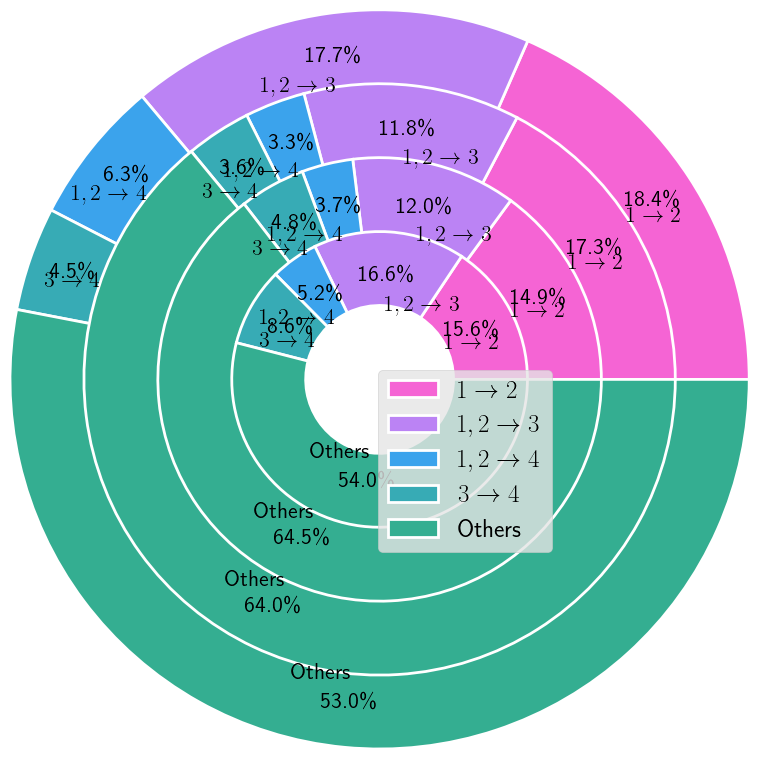

In [6]:
vks_change = None
vks_change_k = ["one_to_two", "onetwo_to_three", "onetwo_to_four", "three_to_four", "others"]
vks_change_vkk = [f'vks-{k}' for k in vks_change_k]
vks_change_pk = [f'vks-f-{k}' for k in vks_change_k]
for k in vks_change_vkk:
    if vks_change is None:
        vks_change = user_pd.groupby("qid")[k].sum().reset_index()
    else:        
        vks_change[k] = user_pd.groupby("qid")[k].sum().reset_index()[k]
print(vks_change[vks_change_vkk].values.sum())
for i, k in enumerate(vks_change_k):
    _k = vks_change_vkk[i]
    _k_p = vks_change_pk[i]
    vks_change[_k_p] = vks_change.apply(lambda item: item[_k]/item[vks_change_vkk].sum(), axis='columns')
vks_change_labels = ["$1\\rightarrow 2$", "$1,2\\rightarrow 3$", "$1,2\\rightarrow 4$", "$3\\rightarrow 4$", "Others"]
colors = sns.color_palette('Spectral')[0:5] #'tab20c')[0:5] #pastel')[0:5]


for c in range(2, -2, -1):
    radius = (3+c)*0.5
    innerradius = radius-0.5
    pctdistance  = 1- 0.3/radius # innerradius
    label_distance= 1 -0.5/radius
    plt.pie(
        vks_change[vks_change.qid==c][vks_change_pk].values[0], 
        explode=None, # to slice the perticuler section explode = [0.003, 0, 0.1, 0, 0]
        autopct='%0.1f\%%', 
        shadow=False,
        textprops={'fontsize': 16, 'weight':'bold'}, 
        colors=sns.color_palette("husl", 9)[-5:][::-1], #colors,
        startangle=0, # start angle of the first section
        wedgeprops={"width":innerradius, "edgecolor":'w', 'linewidth':2}, # the pie ring properties, "width" is the inner 
        pctdistance = pctdistance,
        labeldistance=label_distance, # distance from lalbels to the core.
        radius=radius,
        labels=vks_change_labels,
        )
    print(c, radius)
    if c==2: plt.legend(loc='lower right', fontsize=legend_size) #bbox_to_anchor=(-0.5, 0), 
plt.xticks()
plt.yticks()
plt.show()


In [7]:
def show_statistics(user_pd):
    conditions = np.arange(-1, 3)
    formater = "{:.2f}($\pm{:.2f}$)"
    formater_s = "{}($\pm{}$)"
    print_attr("\\#Participant", [str(user_pd.qid.value_counts()[k]) for k in conditions])
    print_attr("Reading phase duration (minutes) ", [formater_s.format(seconds_to_minutes(user_pd[user_pd.qid==k].search_session_length.mean()), seconds_to_minutes(user_pd[user_pd.qid==k].search_session_length.std())) for k in conditions])
    # print_attr("VK-Q", [str(pre_vks[k].size) + "\t" for k in conditions]))
    print_attr("pretest scores", [formater.format(user_pd[user_pd.qid==k].pretest_score.mean(), user_pd[user_pd.qid==k].pretest_score.std()) for k in conditions])
    print_attr("posttest scores", [formater.format(user_pd[user_pd.qid==k].posttest_score.mean(), user_pd[user_pd.qid==k].posttest_score.std()) for k in conditions])
    print_attr("RPL", [formater.format(user_pd[user_pd.qid==k].RPL.mean(), user_pd[user_pd.qid==k].RPL.std()) for k in conditions])
    print_attr("Delay RPL", [formater.format(user_pd[user_pd.qid == k].DelayRPL.mean(
    ), user_pd[user_pd.qid == k].DelayRPL.std()) for k in conditions])
    print_attr("Flesch Score", [formater.format(user_pd[user_pd.qid==k].readability.mean(), user_pd[user_pd.qid==k].readability.std()) for k in conditions])
    print_attr("\\#Queries", [formater.format(user_pd[user_pd.qid==k].query_num.mean(), user_pd[user_pd.qid==k].query_num.std()) for k in conditions])
    print_attr("\\#Doc", [formater.format(user_pd[user_pd.qid==k].uni_doc.mean(), user_pd[user_pd.qid==k].uni_doc.std()) for k in conditions])
    print_attr("\\#Snippets", [formater.format(user_pd[user_pd.qid==k].uni_snippet.mean(), user_pd[user_pd.qid==k].uni_snippet.std()) for k in conditions])
    print_attr("Between Queryies", [formater.format(0.00, 0.00) for k in conditions])    
    print_attr("Between Docs", [formater.format(user_pd[user_pd.qid==k].between_docs.mean(), user_pd[user_pd.qid==k].between_docs.std()) for k in conditions])
    print_attr("Number Scrolls", [formater.format(user_pd[user_pd.qid==k].page_scrolls.mean(), user_pd[user_pd.qid==k].page_scrolls.std()) for k in conditions])
    print_attr("dwell time", [formater.format(user_pd[user_pd.qid==k].dwell_time.mean(), user_pd[user_pd.qid==k].dwell_time.std()) for k in conditions])
    print_attr("Between Queries: ", [formater.format(user_pd[user_pd.qid==k].between_queries.mean(), user_pd[user_pd.qid==k].between_queries.std()) for k in conditions])    
    print_attr("time before answering", [formater.format(user_pd[user_pd.qid==k].time_before_answering.mean(), user_pd[user_pd.qid==k].time_before_answering.std()) for k in conditions])
    print_attr("time for creating answers", [formater.format(user_pd[user_pd.qid==k].time_creation_answer.mean(), user_pd[user_pd.qid==k].time_creation_answer.std()) for k in conditions])
    print_attr("F1", [formater.format(user_pd[user_pd.qid==k].F1.mean(), user_pd[user_pd.qid==k].F1.std()) for k in conditions])
    print_attr("EM", [formater.format(user_pd[user_pd.qid==k].EM.mean(), user_pd[user_pd.qid==k].EM.std()) for k in conditions])
    print_attr("Answer non-stopwords: ", [formater.format(user_pd[user_pd.qid==k].answer_word_length.mean(), user_pd[user_pd.qid==k].answer_word_length.std()) for k in conditions])
    print_attr("summary term coverage: ", [formater.format(user_pd[user_pd.qid==k].summary_term_coverage.mean(), user_pd[user_pd.qid==k].summary_term_coverage.std()) for k in conditions])
    print_attr("between queries: ",  [formater.format(user_pd[user_pd.qid==k].between_queries.mean(), user_pd[user_pd.qid==k].between_queries.std()) for k in conditions])
    print_attr("T-Depth: ",  [formater.format(user_pd[user_pd.qid==k].t_depth.mean(), user_pd[user_pd.qid==k].t_depth.std()) for k in conditions])
    print_attr("F-Fact: ",  [formater.format(user_pd[user_pd.qid==k].f_facts.mean(), user_pd[user_pd.qid==k].f_facts.std()) for k in conditions])
    

In [8]:
show_statistics(user_pd)

\#Participant & 32	&37	&36	&39\\
Reading phase duration (minutes)  & 19m47s($\pm1m46s$)	&21m5s($\pm3m16s$)	&20m6s($\pm2m30s$)	&20m18s($\pm2m56s$)\\
pretest scores & 1.84($\pm0.51$)	&1.75($\pm0.44$)	&1.78($\pm0.45$)	&1.94($\pm0.59$)\\
posttest scores & 2.42($\pm0.55$)	&2.13($\pm0.49$)	&2.16($\pm0.46$)	&2.51($\pm0.52$)\\
RPL & 0.23($\pm0.18$)	&0.14($\pm0.14$)	&0.13($\pm0.12$)	&0.23($\pm0.15$)\\
Delay RPL & 0.17($\pm0.20$)	&0.11($\pm0.12$)	&0.10($\pm0.12$)	&0.16($\pm0.19$)\\
Flesch Score & 52.00($\pm12.33$)	&49.67($\pm17.06$)	&52.56($\pm13.23$)	&56.49($\pm13.42$)\\
\#Queries & 6.09($\pm3.90$)	&3.49($\pm2.80$)	&3.11($\pm2.78$)	&3.49($\pm3.16$)\\
\#Doc & 13.44($\pm6.65$)	&7.49($\pm3.01$)	&9.47($\pm5.14$)	&9.10($\pm3.89$)\\
\#Snippets & 45.09($\pm21.16$)	&31.57($\pm17.55$)	&32.47($\pm16.61$)	&28.38($\pm15.70$)\\
Between Queryies & 0.00($\pm0.00$)	&0.00($\pm0.00$)	&0.00($\pm0.00$)	&0.00($\pm0.00$)\\
Between Docs & 18.78($\pm16.89$)	&20.20($\pm13.70$)	&20.40($\pm19.73$)	&19.85($\pm20.87$)\\
Nu